<a href="https://colab.research.google.com/github/edilop/Proyecto_final_Skills_Tech/blob/main/Proyecto_Final_Forecasting_de_ventas_Walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Skills Tech
#Proyecto Integrador - Generación 6

###Objetivo
#### En este proyecto, el alumno aplicará las habilidades obtenidas en el curso para generar un modelo que pueda hacer predicciones de ventas.

###Escenario
####Eres un científico de datos dentro de la consultoría “El oráculo”, tienes la asignación de trabajar en una empresa de retail para predecir sus ventas semanales a diferentes niveles muestrales, a nivel tienda.

##Sección 1. Obtención de datos

###1.1.Importamos las librerías

In [ ]:
#Versión de python 
!python --version

Python 3.8.16


In [ ]:
#Manipulación de datos
import numpy as np
import pandas as pd
import datetime #Manipulación de tiempo
from time import process_time_ns #Medición de tiempo

#Librerías estadísticas
from statsmodels.tsa.stattools import pacf, acf #Autocorrelaciones
from scipy import stats #Prueba de Kruskal-Wallis

#Visualización de datos
import plotly.express as px #Librería de gráficos
import plotly.graph_objects as go #Librería plotly para objetos gráficos
from plotly.subplots import make_subplots #Subgráficos dentro de un aréa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Gráficos acf, pacf

#Seteo de opciones
pd.options.plotting.backend = "plotly" #Cambia motor de gráficas de pandas a plotly
pd.options.display.float_format = '{:,.2f}'.format #Configuramos los valores float a 2 decimales

#Machine Learning
#Instalamos librerías
!pip install pmdarima #Autoarima
!pip install neuralprophet #Neural prophet

#Importamos librerías de ML
import pmdarima #Auto arima
from sklearn.metrics import mean_squared_error #RMSE
from prophet import Prophet #Facebook prophet
from neuralprophet import NeuralProphet #Neural Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###1.2.Carga del set de datos

In [ ]:
#Cargamos los datos desde el drive
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Skills Tech/Proyecto Final/Walmart_Store_sales.csv', 
                   encoding='utf-8')
walmart_df = pd.DataFrame(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Sección 2. Análisis Exploratorio

###2.1.Descripción de los Datos

In [ ]:
#Muestra del dataframe.
data.sample(n=10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
5747,41,13-08-2010,"1,285,976.53",0,70.24,2.72,190.26,7.33
1148,9,05-03-2010,"507,297.88",0,48.43,2.62,214.91,6.42
3925,28,29-04-2011,"1,222,367.90",0,68.27,4.15,129.00,13.74
4739,34,25-06-2010,"895,800.07",0,78.47,2.65,126.13,9.59
3501,25,03-06-2011,"737,551.74",0,70.69,3.92,208.36,7.29
4973,35,23-03-2012,"760,671.10",0,57.30,3.90,141.63,8.74
4766,34,31-12-2010,"902,109.69",1,34.11,2.96,127.09,10.21
1229,9,23-09-2011,"506,743.78",0,74.42,3.47,219.97,6.40
2253,16,02-03-2012,"464,189.09",0,23.40,3.19,196.96,6.16
76,1,22-07-2011,"1,396,926.82",0,85.77,3.65,215.42,7.96


In [ ]:
#Dimensiones del dataframe
walmart_df.shape

(6435, 8)

In [ ]:
#Columnas del dataframe
walmart_df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [ ]:
#Metadata
walmart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
#Resumen
walmart_df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,"6,435.00","6,435.00","6,435.00","6,435.00","6,435.00","6,435.00","6,435.00"
mean,23.00,"1,046,964.88",0.07,60.66,3.36,171.58,8.00
std,12.99,"564,366.62",0.26,18.44,0.46,39.36,1.88
min,1.00,"209,986.25",0.00,-2.06,2.47,126.06,3.88
25%,12.00,"553,350.10",0.00,47.46,2.93,131.74,6.89
50%,23.00,"960,746.04",0.00,62.67,3.44,182.62,7.87
75%,34.00,"1,420,158.66",0.00,74.94,3.73,212.74,8.62
max,45.00,"3,818,686.45",1.00,100.14,4.47,227.23,14.31


In [ ]:
#Conteo de datos nulos.
walmart_df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

###2.2.Análisis de relación entre variables

In [ ]:
#Dataframe de variables agrupadas por ventas
correlacion_df = walmart_df.groupby('Date').agg({'Weekly_Sales':'sum',
                                            'Holiday_Flag':'mean',
                                            'Temperature':'mean',
                                            'Fuel_Price':'mean',
                                            'CPI':'mean',
                                            'Unemployment':'mean'})\
                                            .reset_index()
#Calculamos la correlación
cor = correlacion_df.corr()

#Graficamos la correlación con un heatmap
cor_heatm = go.Figure()
cor_heatm.add_trace(go.Heatmap(z=cor,
           x=cor.columns,
           y=cor.columns,
           zmin=-1,
           zmax=1,
           colorscale=px.colors.diverging.RdBu,
           showscale=True,
           text=cor,
           texttemplate='%{text:.2f}',
           )
)
cor_heatm.update_layout(template='ggplot2', yaxis_autorange='reversed', title='Heatmap de correlación entre variables')
cor_heatm.show()

In [ ]:
#Historico de ventas de todas las sucursales                               
#Arreglo con los días festivos
fechas = ['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
          '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
          '2012-11-23', '2012-02-10',]
#Dataframe
linear = walmart_df.loc[:,['Date', 'Store', 'Weekly_Sales']]
linear = linear.groupby(['Store', 'Date']).agg({'Weekly_Sales': 'sum'})\
                                          .reset_index()
linear['Date'] = pd.to_datetime(linear.Date)
linear = linear.sort_values(by='Date')
#Graficamos el histograma de ventas de todas las sucursales
fig = px.line(linear, x='Date', y='Weekly_Sales', color='Store', 
              title='Historico de ventas de las 45 sucursales', 
              template='seaborn',)
#Trazamos los holidays como lineas negras verticales
for i in range(len(fechas)):
  fig.add_vline(x=fechas[i], line_width=3, line_dash="dash", 
                line_color="black")
fig.show()

In [ ]:
#Consolidado de ventas y boxplot.
#Dataframe
ventas_totales = walmart_df.groupby(['Date']).agg({'Weekly_Sales': 'sum'}) \
                .reset_index()
ventas_totales['Date'] = pd.to_datetime(ventas_totales.Date)
ventas_totales = ventas_totales.sort_values(by='Date')
#Graficamos el histograma y el caja de bigotes de la evolución de la ventas.
fig_totales = make_subplots(rows=1, cols=2,
                      subplot_titles=('Histórico de Ventas', 
                                      'Boxplot de Ventas'))
#Histogram
fig_totales.add_trace(go.Scatter(x=ventas_totales.Date, 
                                 y=ventas_totales.Weekly_Sales), col=1, row=1)
#Boxplot
fig_totales.add_trace(go.Box(x=ventas_totales.Weekly_Sales, boxpoints='all', 
                             boxmean=True), col=2, row=1)

#Config
fig_totales.update_layout(showlegend=False, template='seaborn', 
                          title='Histórico y Boxplot de ventas consolidadas')
fig_totales.show()

###2.3.Preguntas de Exploración

####2.3.1.¿Qué tienda tiene el máximo de ventas?

In [ ]:
#Obtenemos las 5 sucursales con más ventas
question_231 = walmart_df.groupby(['Store']).agg(
    {'Weekly_Sales': 'sum'}).sort_values(by='Weekly_Sales', 
                                        ascending=False).reset_index().head()
question_231

,Store,Weekly_Sales
0,20,"301,397,792.46"
1,4,"299,543,953.38"
2,14,"288,999,911.34"
3,13,"286,517,703.80"
4,2,"275,382,440.98"


In [ ]:
#Gráfico de top 5 de tiendas con las mejores ventas
question_231['Store'] = question_231['Store'].astype(str)
fig_q231 = px.funnel(question_231, x='Weekly_Sales', 
                     y='Store',
                     title='Top 5 tiendas con más ventas',
                     template='seaborn',
                     color='Weekly_Sales'
                     )
fig_q231.show()


####2.3.2.¿Qué tienda tiene la desviación estándar máxima, es decir, las ventas varían mucho. Además, averigüe el coeficiente de desviación medio?

In [ ]:
#Obtenemos las 5 sucursales con mayor desviación estándar
question_232 = walmart_df.loc[:,['Store', 'Weekly_Sales']]
question_232.columns = ['Store', 'Desv_std_max']
question_232 = question_232.groupby(['Store']).std().sort_values(
    by='Desv_std_max', ascending=False).reset_index()

#Imprimimos el resultado
print(f'La sucursal con mayor desviación estándar es: {question_232.iloc[0,0]} \
con un valor de: {question_232.Desv_std_max.max():.2f}')

La sucursal con mayor desviación estándar es: 14 con un valor de: 317569.95


In [ ]:
#Calculamos el coeficiente de desviación media
#Seleccionamos la columna a analizar
column = walmart_df[walmart_df.Store == 14].loc[:,'Weekly_Sales']

#Calculamos la media y la desviación estándar
mean = column.mean()
std = column.std()

#Calculamos el coeficiente de desviación media
coef_desv_media = (std/mean)*100

#Imprimimos el resultado
print(f'El coeficiente de desviación media es de: {coef_desv_media:.2f}%')

El coeficiente de desviación media es de: 15.71%


In [ ]:
#Graficamos el resultado
fig_q232 = px.histogram(column,
                        x='Weekly_Sales',
                        y='Weekly_Sales',
                        marginal='box',
                        template='seaborn',
                        title='Distribución de ventas Store 14'
                        )
fig_q232.show()

####2.3.3.¿Qué tienda/s tiene una buena tasa de crecimiento trimestral en el tercer trimestre de 2012?

In [ ]:
#Creamos un nuevo dt para extraer la info necesaria.
quarters_df = walmart_df.loc[:,['Store', 'Date', 'Weekly_Sales']]
#Cambiamos el tipo de columna Date a tipo fecha.
quarters_df['Date'] = pd.to_datetime(quarters_df["Date"])
#Creamos la columna 'Quarters' para identififcar los trimestres
quarters_df['Quarters'] =  quarters_df['Date'].dt.quarter
#Creamos la columna 'Years' para identificar los años.
quarters_df['Years'] = quarters_df['Date'].dt.year
#Seleccionamos solo los trimestres 2 y 3
quarters_df = quarters_df[(quarters_df['Quarters'] == 2) | 
                          (quarters_df['Quarters'] == 3)]
quarters_df.head()

,Store,Date,Weekly_Sales,Quarters,Years
0,1,2010-05-02,"1,643,690.90",2,2010
4,1,2010-05-03,"1,554,806.68",2,2010
9,1,2010-09-04,"1,545,418.53",3,2010
10,1,2010-04-16,"1,466,058.28",2,2010
11,1,2010-04-23,"1,391,256.12",2,2010


In [ ]:
#Creamos el dataframe de trabajo para responder la pregunta 3.
question3_df = pd.pivot_table(quarters_df,values='Weekly_Sales', 
                              index=['Store', 'Quarters'],
                              columns='Years', aggfunc='sum',)
question3_df.head()

Years                   2010          2011          2012
Store Quarters                                          
1     2        19,505,567.64 20,243,682.63 21,036,965.58
      3        17,662,309.35 21,053,548.19 18,633,209.98
2     2        25,337,280.47 24,142,687.77 25,085,123.61
      3        22,402,176.23 25,220,933.79 22,396,867.61
3     2         4,955,456.35  5,192,794.22  5,562,668.16

#####2.3.3.1. Análisis de crecimientos del 3er trimestre por cada año.

In [ ]:
#Creamos el dt.
question3_df_1 = question3_df.copy().reset_index()
#Añadimos las columnas de crecimineto por cada año de trimestres 2 y 3.
# Función para calcular crecimiento entre 2do y 3er trimestre.
def crecimiento(df, anio):
  """
  Calcula las series "Tasa de crecimiento" del dataframe.
  Calcula el crecimiento porcentual entre el 2do y 3er periodo de cada una de las sucur-
  sales, y los añade a las Series de 'Tasa de crecimiento'.

  Parametros:
  df(pd.Series): Las ventas reflejadas en la serie seleccionada del dataframe.
  anio: El año de la serie en la que ocurren las ventas de df.

  Salida:
  Devuelve una serie con los cálculos de los crecimientos, 
  """
  for i in range(len(df)):
    if df.loc[i, 'Quarters'] == 3:
      df.loc[i, f'Tasa de crecimiento {anio}'] = ((df.loc[i, anio]-df.loc[i-1, anio])/
                                                  df.loc[i-1, anio])*100
    else:
      df.loc[i, f'Tasa de crecimiento {anio}'] = np.nan
  pass

#Aplicacion la función 'crecimiento' a los años 2010, 2011, 2012
crecimiento(question3_df_1, 2010)
crecimiento(question3_df_1, 2011)
crecimiento(question3_df_1, 2012)

#Reordenamos las columnas del dataframe
question3_df_1 = question3_df_1.reindex(columns=['Store', 'Quarters', 2012, 
                                                 'Tasa de crecimiento 2012',
                                                 2011, 'Tasa de crecimiento 2011', 
                                                 2010, 'Tasa de crecimiento 2010'])

question3_df_1.head()

Years,Store,Quarters,2012,Tasa de crecimiento 2012,2011,Tasa de crecimiento 2011,2010,Tasa de crecimiento 2010
0,1,2,"21,036,965.58",NaN,"20,243,682.63",NaN,"19,505,567.64",NaN
1,1,3,"18,633,209.98",-11.43,"21,053,548.19",4.00,"17,662,309.35",-9.45
2,2,2,"25,085,123.61",NaN,"24,142,687.77",NaN,"25,337,280.47",NaN
3,2,3,"22,396,867.61",-10.72,"25,220,933.79",4.47,"22,402,176.23",-11.58
4,3,2,"5,562,668.16",NaN,"5,192,794.22",NaN,"4,955,456.35",NaN


In [ ]:
#Grafico con plotly go
fig3_1 = make_subplots(rows=3, cols=1,
                      subplot_titles=('2012','2011','2010'))

#2012
fig3_1.add_trace(
    go.Bar(x=question3_df_1['Store'], y=question3_df_1['Tasa de crecimiento 2012']),
           row=1, col=1
)

#2011
fig3_1.add_trace(
    go.Bar(x=question3_df_1['Store'], y=question3_df_1['Tasa de crecimiento 2011']),
           row=2, col=1
)

#2010
fig3_1.add_trace(
    go.Bar(x=question3_df_1['Store'], y=question3_df_1['Tasa de crecimiento 2010']),
           row=3, col=1
)

fig3_1.update_layout(showlegend=False, template='seaborn', 
                     title_text='Tasa de crecimiento en % del 3er trimestre por año por sucursal')
fig3_1.update_xaxes(tickvals=question3_df_1['Store'], zeroline=True)
fig3_1.update_yaxes(zeroline=True, zerolinecolor='black')

fig3_1.show()

##### 2.3.3.2. Análisis de crecimiento del 3er trimestre entre cada año.

In [ ]:
#Creamos el dt.
question3_df_2 = question3_df.reset_index()
question3_df_2 = question3_df_2[question3_df_2['Quarters'] == 3]
# question3_df_2 = question3_df.copy().reset_index()
question3_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 1 to 89
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Store     45 non-null     int64  
 1   Quarters  45 non-null     int64  
 2   2010      45 non-null     float64
 3   2011      45 non-null     float64
 4   2012      45 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 2.1 KB


In [ ]:
#Añadimos las columnas de crecimiento entre años.
#Crecimiento entre año 2010 a 2011.
question3_df_2['Tasa de crecimiento 2010-2011'] = ((question3_df_2[2011] - question3_df_2[2010])/question3_df_2[2010])*100
#Crecimiento entre año 2011 a 2012.
question3_df_2['Tasa de crecimiento 2011-2012'] = ((question3_df_2[2012] - question3_df_2[2011])/question3_df_2[2011])*100
#Reordenamos las columnas del dataframe.
question3_df_2 = question3_df_2.reindex(columns=['Store', 
                                                 'Quarters', 
                                                 2012, 
                                                 'Tasa de crecimiento 2011-2012', 
                                                 2011,
                                                 'Tasa de crecimiento 2010-2011', 
                                                 2010,])
question3_df_2.head()

Years,Store,Quarters,2012,Tasa de crecimiento 2011-2012,2011,Tasa de crecimiento 2010-2011,2010
1,1,3,"18,633,209.98",-11.50,"21,053,548.19",19.20,"17,662,309.35"
3,2,3,"22,396,867.61",-11.20,"25,220,933.79",12.58,"22,402,176.23"
5,3,3,"4,966,495.93",-7.03,"5,341,819.41",21.81,"4,385,215.18"
7,4,3,"25,652,119.35",-11.87,"29,105,608.58",28.28,"22,689,554.03"
9,5,3,"3,880,621.88",-8.24,"4,228,923.87",20.62,"3,506,112.88"


In [ ]:
#Gráfico con plotly go
fig3_2 = make_subplots(rows=2, cols=1,
                      subplot_titles=('2011 - 2012','2010 - 2011'))
#Tasa de crecimiento 2011-2012
fig3_2.add_trace(
    go.Bar(x=question3_df_2['Store'], y=question3_df_2['Tasa de crecimiento 2011-2012']),
    row=1, col=1
)

#Tasa de crecimiento 2010-2011
fig3_2.add_trace(
    go.Bar(x=question3_df_2['Store'], y=question3_df_2['Tasa de crecimiento 2010-2011']),
    row=2, col=1
)

fig3_2.update_layout(showlegend=False, template='seaborn', 
                     title_text='Tasa de crecimiento % del 3er trimestre entre años',
                     xaxis_tickangle=-70
                     )
fig3_2.update_xaxes(tickvals=question3_df_2['Store'])
fig3_2.update_yaxes(zeroline=True, zerolinecolor='black')

fig3_2.show()

In [ ]:
#Crecimiento por ventas.
#Preparamos el dataframe
question3_df_ventas = question3_df.copy().reset_index()
question3_df_ventas = question3_df_ventas.loc[:,['Store', 'Quarters', 2012]]

#Calculamos la columna de crecimiento
for i in range(len(question3_df_ventas)):
  if question3_df_ventas.loc[i, 'Quarters'] == 3:
    question3_df_ventas.loc[i, 'Tasa de crecimiento 2012'] = (question3_df_ventas.loc[i, 2012] - question3_df_ventas.loc[i-1, 2012])
  else:
    question3_df_ventas.loc[i, 'Tasa de crecimiento 2012'] = np.nan

question3_df_ventas.head()

Years,Store,Quarters,2012,Tasa de crecimiento 2012
0,1,2,"21,036,965.58",NaN
1,1,3,"18,633,209.98","-2,403,755.60"
2,2,2,"25,085,123.61",NaN
3,2,3,"22,396,867.61","-2,688,256.00"
4,3,2,"5,562,668.16",NaN


In [ ]:
df_1 = question3_df_ventas[question3_df_ventas['Quarters']==2].loc[:,['Store','Quarters',2012]]
df_2 = question3_df_ventas[question3_df_ventas['Quarters']==3].loc[:,['Store','Quarters',2012]]

In [ ]:
#Graficamos el crecimiento del año 2012
fig3_3 = make_subplots(specs=[[{'secondary_y':True}]])
fig3_3.add_trace(
    go.Bar(x=df_1['Store'], y=df_1[2012], name='2do trim'),
    secondary_y=False
)
#Ventas 2do trim
fig3_3.add_trace(
    go.Bar(x=df_1['Store'], y=df_2[2012], name = '3er trim'),
    secondary_y = False
)
#Ventas 3er trim
fig3_3.add_trace(
    go.Scatter(x=df_1['Store'], 
               y=question3_df_ventas['Tasa de crecimiento 2012'].dropna(),
               name = 'Crecimiento', mode = 'lines+markers', 
               line=dict(color = '#7d1a0c')),
               secondary_y = True,
)
#Diferencia entre 2do y 3er trim
fig3_3.update_layout(showlegend=True, template='seaborn', 
                     title_text='Tasa de crecimiento del 3er trimestre 2012',
                     barmode='group')

fig3_3.update_xaxes(tickvals=question3_df_ventas['Store'])
fig3_3.update_yaxes(title_text = 'Ventas', secondary_y = False)
fig3_3.update_yaxes(title_text = 'Crecimiento', secondary_y = True,
                    zeroline = True, zerolinecolor ='#7d1a0c')

fig3_3.show()

In [ ]:
question3_df_ventas.loc[question3_df_ventas['Tasa de crecimiento 2012'] == question3_df_ventas['Tasa de crecimiento 2012'].max()]

Years,Store,Quarters,2012,Tasa de crecimiento 2012
31,16,3,"6,441,311.11","-184,822.33"


In [ ]:
question3_df_1.loc[question3_df_1['Tasa de crecimiento 2012'] == question3_df_1['Tasa de crecimiento 2012'].max()]

Years,Store,Quarters,2012,Tasa de crecimiento 2012,2011,Tasa de crecimiento 2011,2010,Tasa de crecimiento 2010
31,16,3,"6,441,311.11",-2.79,"7,636,743.21",25.04,"6,301,675.57",3.90


In [ ]:
question3_df_2.loc[question3_df_2['Tasa de crecimiento 2011-2012'] == question3_df_2['Tasa de crecimiento 2011-2012'].max()]

Years,Store,Quarters,2012,Tasa de crecimiento 2011-2012,2011,Tasa de crecimiento 2010-2011,2010
87,44,3,"4,020,486.01",-3.98,"4,187,060.18",23.25,"3,397,141.03"


####2.3.4.¿Algunas festividades tienen un impacto negativo en las ventas. Averigüe los días festivos que tienen ventas más altas que las ventas medias en temporada no festiva para todas las tiendas juntas?

In [ ]:
#Creamos el frame de trabajo
question4_df = walmart_df.loc[:,['Store', 'Date','Weekly_Sales','Holiday_Flag']]
#Cambiamos la columna 'Date' a tipo fecha.
question4_df['Date'] = pd.to_datetime(question4_df['Date'], dayfirst=True)

In [ ]:
#Identificamos los días festivos.
superbowl = ['2010-02-12', '2011-02-11','2012-02-10','2013-02-08']
dia_trabajo = ['2010-09-10','2011-09-09','2012-09-07','2013-09-06']
accion_gracias=['2010-11-26','2011-11-25','2012-11-23','2013-11-29']
navidad = ['2010-12-31','2011-12-30','2012-12-28','2013-12-27']

In [ ]:
#Añadimos los días festivos al dataframe.
##Creamos la función que agregará los días festivos al dataframe.
def isHoliday (x):
  """
  Compara la fecha ingresada 'x' con varias listas, donde se encuentran almace-
  nadas las fechas de 4 diferentes días festivos, si la fecha coincide, devolve-
  rá el día festivo al que corresponda.

  Parametros:
  x(date): Fecha a buscar en las listas.

  Salida:
  Devuelve el nombre del día festivo según sea Superbolw, Día del trabajo, Acción
  de gracias o Navidad.
  """
  if x in superbowl:
    return 'Superbowl'
  elif x in dia_trabajo:
    return 'Día de Trabajo'
  elif x in accion_gracias:
    return 'Acción de gracias'
  elif x in navidad:
    return 'Navidad'
  else:
    return 'None'
##Agregamos la columna 'Festividad' al dataframe.
question4_df['Festividad'] = question4_df['Date'].dt.strftime('%Y-%m-%d').apply(isHoliday)

In [ ]:
#Comprobamos los valores de la columna 'Festividad'.
question4_df['Festividad'].value_counts()

None                 5985
Superbowl             135
Día de Trabajo        135
Acción de gracias      90
Navidad                90
Name: Festividad, dtype: int64

In [ ]:
#Creamos la columna 'Years'
question4_df['Years'] = question4_df['Date'].dt.year
question4_df['Years'].value_counts()

2011    2340
2010    2160
2012    1935
Name: Years, dtype: int64

In [ ]:
#Agrupamos los datos para obtener los valores de las ventas agrupados por fecha.
ventas_perdate = question4_df.groupby(['Date', 'Years', 'Festividad'],
                                      as_index=False).agg({'Weekly_Sales': 'sum'})
ventas_perdate.sort_values('Date')

,Date,Years,Festividad,Weekly_Sales
0,2010-02-05,2010,None,"49,750,740.50"
1,2010-02-12,2010,Superbowl,"48,336,677.63"
2,2010-02-19,2010,None,"48,276,993.78"
3,2010-02-26,2010,None,"43,968,571.13"
4,2010-03-05,2010,None,"46,871,470.30"
...,...,...,...,...
138,2012-09-28,2012,None,"43,734,899.40"
139,2012-10-05,2012,None,"47,566,639.31"
140,2012-10-12,2012,None,"46,128,514.25"
141,2012-10-19,2012,None,"45,122,410.57"


In [ ]:
#Filtramos los días festivos.
holiday_df = ventas_perdate[ventas_perdate['Festividad'] != 'None']
holiday_df.head()

,Date,Years,Festividad,Weekly_Sales
1,2010-02-12,2010,Superbowl,"48,336,677.63"
31,2010-09-10,2010,Día de Trabajo,"45,634,397.84"
42,2010-11-26,2010,Acción de gracias,"65,821,003.24"
47,2010-12-31,2010,Navidad,"40,432,519.00"
53,2011-02-11,2011,Superbowl,"47,336,192.79"


In [ ]:
#Gráfico
figura = go.Figure()
figura.add_trace(go.Scatter(x=ventas_perdate['Date'], y=ventas_perdate['Weekly_Sales'],
                         name='Ventas'))

figura.add_trace(go.Scatter(x=holiday_df['Date'], y=holiday_df['Weekly_Sales'], text=holiday_df['Festividad'],
                            mode='markers+text', name='Holidays', textposition='top center'))
figura.update_layout(template='seaborn', title='Historico de ventas totales vs Holidays')
figura.show()

######2.3.4.1.Análisis de relación entre días festivos y evolución de ventas

In [ ]:
x = ventas_perdate['Weekly_Sales'][ventas_perdate['Festividad']!='None']
y = ventas_perdate['Weekly_Sales'][ventas_perdate['Festividad']=='None']

In [ ]:
results = stats.kruskal(x,y)
x, y = results
print(f'p value = {y:.2f} > 0.05, por lo tanto, los holidays están relacionados con las ventas')

p value = 0.08 > 0.05, por lo tanto, los holidays están relacionados con las ventas


##Sección 3. Modelado

###3.1.Autoarima

In [ ]:
#Creamos el dataframe para trabajar con ARIMA.
arima_df = ventas_perdate.loc[:,['Date', 'Weekly_Sales']]
arima_df.set_index('Date', inplace=True)
arima_df.head()

,Weekly_Sales
Date,
2010-02-05,"49,750,740.50"
2010-02-12,"48,336,677.63"
2010-02-19,"48,276,993.78"
2010-02-26,"43,968,571.13"
2010-03-05,"46,871,470.30"


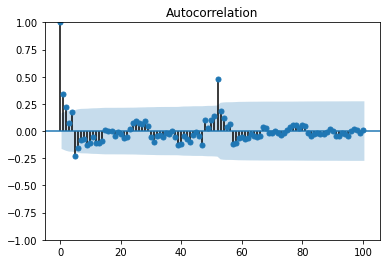

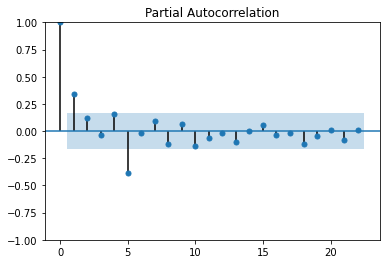

In [ ]:
#Graficamos la autocorrelación de la serie origin
acf_fig = plot_acf(arima_df, lags=100)
pacf_fig = plot_pacf(arima_df, method='ywm')

In [ ]:
#Aplicamos la prueba a de Dickey-Fuller para probar estacionalidad.
adf_test = pmdarima.arima.ADFTest(alpha=0.05)
adf_test.should_diff(arima_df['Weekly_Sales'])

(0.01, False)

In [ ]:
t1_start = process_time_ns() 
#Aplicamos el modelo autoarima
stepwise_model=pmdarima.auto_arima(arima_df,
                     start_p=1,
                     start_q=1,
                     test='adf',
                     max_p=3,
                     max_q=3,
                     m=52,
                      d=1,
                      seasonal=True,
                      start_P=0,
                      D=1,
                      trace=True,
                      error_action='warn',
                      suppress_warnings=True,
                      stepwise=True,
                      n_fits=10
                     )

t1_stop = process_time_ns()

stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=2881.254, Time=7.22 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2907.540, Time=0.45 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2881.765, Time=5.97 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=2879.447, Time=9.94 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=2891.762, Time=2.57 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=21.12 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=2872.734, Time=12.30 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=2874.700, Time=37.43 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=2881.252, Time=8.15 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=2874.202, Time=25.67 sec
 ARIMA(0,1,2)(0,1,2)[52]             : AIC=2874.405, Time=12.30 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=2874.792, Time=9.38 sec
 ARIMA(1,1,2)(0,1,2)[52]             : AIC=2876.412, Time=24.13 sec
 ARIMA(0,1,1)(0,1,2)[52] intercept   : AIC=2874.750, Time=17.15 sec

Best model:  ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 52)   Log Likelihood               -1432.367
Date:                                 Tue, 10 Jan 2023   AIC                           2872.734
Time:                                         21:03:48   BIC                           2882.734
Sample:                                     02-05-2010   HQIC                          2876.767
                                          - 10-26-2012                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1525      0.036     -4.219      0.000      -0.223      -0.082
ma.S.L52      -0.2267      0.067     -3.407      0.001      -0.357      -0.096
ma.S.L104     -0.1578      0.117     -1.344      0.179      -0.388       0.072
sigma2      4.089e+12   5.17e-15   7.91e+26      0.000    4.09e+12    4.09e+12
===================================================================================
Ljung-Box (L1) (Q):                   9.39   Jarque-Bera (JB):                 5.47
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               1.40   Skew:                             0.06
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.28e+42. Standard errors may be unstable.
"""

In [ ]:
#Separar dataset en train y test.
train_arima = arima_df.iloc[:-30]
test_arima = arima_df.iloc[-30:]
print(train_arima.shape, test_arima.shape)

(113, 1) (30, 1)


In [ ]:
#Entrenamos el modelo
stepwise_model.fit(train_arima)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 2, 52),
      suppress_warnings=True, with_intercept=False)

In [ ]:
#Testeamos el modelo
forecast_arima = stepwise_model.predict(n_periods=len(test_arima))
forecast_arima = pd.DataFrame(forecast_arima, index=test_arima.index, columns=['Predicted_Weekly_Sales'])

#Gráfico
fig_arima = go.Figure([go.Scatter(x=test_arima.index, y=test_arima['Weekly_Sales'], name='Test Weekly Sales'),
                    go.Scatter(x=forecast_arima.index,
                               y=forecast_arima['Predicted_Weekly_Sales'], name='Predicted Weekly Sales')])
fig_arima.update_layout(template='seaborn', title='Weekly Sales vs Predicted Weekly Sales with Auto arima')
fig_arima.show()

In [ ]:
#Calculamos el error
#Función para calcular el RMSE
def rmse(actual, prediccion):
  """
  Calcula el error cuadrático medio de un modelo de ML.

  Parametros:
  actual(np.array): Array de numpy con los valores reales
  prediccion(np.array): Array de cumpy con los valores predichos por el modelo.

  Salida:
  float: El valor RMSE calculado del modelo
  """
  RMSE = mean_squared_error(actual, prediccion, squared=False)
  return RMSE

#Función para calcular MAPE
def mape(actual, prediccion):
  """
  Calcula el error porcentual absoluto medio de un modelo de ML.

  Parametros:
  actual(np.array): Array de numpy con los valores reales
  prediccion(np.array): Array de cumpy con los valores predichos por el modelo.

  Salida:
  float: El valor MAPE
  """
  actual, prediccion = np.array(actual), np.array(prediccion)
  MAPE = np.mean(np.abs(actual-prediccion)/actual) * 100
  return MAPE

In [ ]:
x =  t1_stop-t1_start

In [ ]:
#Guardamos los resultados en un dataframe
error_df = pd.DataFrame(columns = ['Modelo', 'RMSE', 'MAPE'])
error_df.loc[0,'Modelo'] = 'Autoarima'
error_df.loc[0,'RMSE'] = rmse(test_arima.Weekly_Sales, forecast_arima.Predicted_Weekly_Sales)
error_df.loc[0,'MAPE'] = mape(test_arima.Weekly_Sales, forecast_arima.Predicted_Weekly_Sales)
error_df.loc[0, 'Speed (seg)'] = x/1000000000
error_df

,Modelo,RMSE,MAPE,Speed (seg)
0,Autoarima,"1,744,269.76",2.49,326.24


###3.2.Prophet

In [ ]:
#Creamos el dataframe.
prophet_df = arima_df.copy().reset_index()
#Cambiamos el nombre de las columnas por requerimiento del modelo
prophet_df.columns=['ds','y']
#Separamos los sets para entrenamiento y prueba.
train_prophet = prophet_df.iloc[:-30]
test_prophet = prophet_df.iloc[-30:]

In [ ]:
#Iniciamos la función de toma de tiempo
t2_start = process_time_ns()
#Instanciamos el objeto prophet
m = Prophet()
#Entrenamos el modelo
m.fit(train_prophet)
#Hacemos el forecast con el modelo
future = m.make_future_dataframe(periods=30, freq='W-FRI')
forecast_prophet = m.predict(future)
forecast_prophet.head()
#Terminamos la función de toma de tiempo
t2_stop = process_time_ns()
x = t2_stop-t2_start

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpluwqusee/g0zhsd2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpluwqusee/qrfddjtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21167', 'data', 'file=/tmp/tmpluwqusee/g0zhsd2r.json', 'init=/tmp/tmpluwqusee/qrfddjtk.json', 'output', 'file=/tmp/tmpluwqusee/prophet_modelanirqj6i/prophet_model-20230110210401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


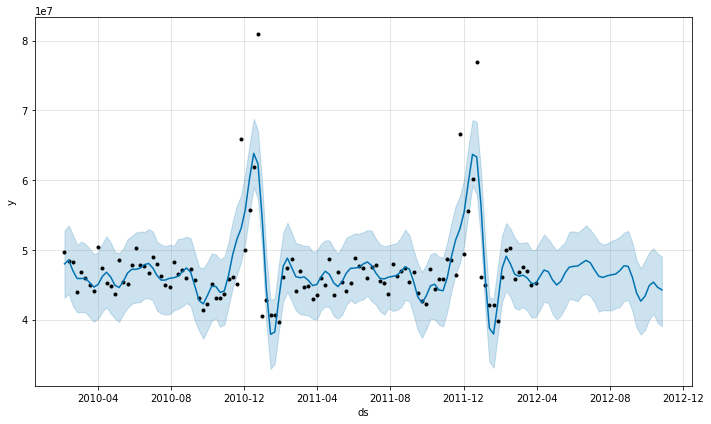

In [ ]:
#Hacemos un plot del modelo
m.plot(forecast_prophet);

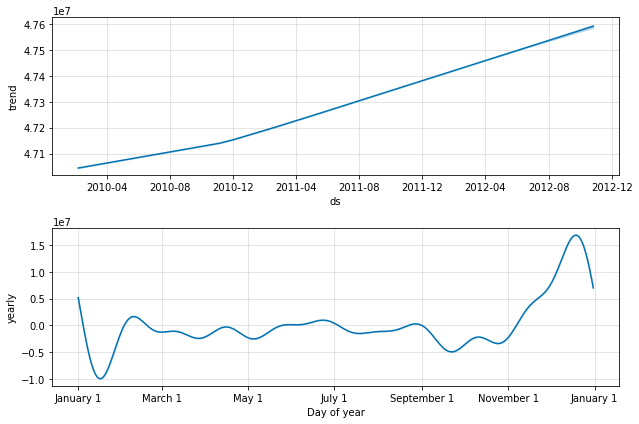

In [ ]:
#Plot de los componentes del modelo
m.plot_components(forecast_prophet);

In [ ]:
#Graficamos una comparación de los datos del test con los datos predichos por el
#modelo
fig_prophet = go.Figure([go.Scatter(x=test_prophet['ds'], y=test_prophet['y'], name='Test sales'),
                    go.Scatter(x=forecast_prophet['ds'].iloc[-30:],
                               y=forecast_prophet['yhat'].iloc[-30:], name='Predicted sales')])
fig_prophet.update_layout(template='seaborn', title='Test Sales vs Predicted Sales with Prophet')
fig_prophet.show()

In [ ]:
#Calculamos el error
#Guardamos los resultados en un dataframe
error_df.loc[1,'Modelo'] = 'Prophet'
error_df.loc[1,'RMSE'] = rmse(test_prophet.y, forecast_prophet.yhat.iloc[-30:])
error_df.loc[1,'MAPE'] = mape(test_prophet.y, forecast_prophet.yhat.iloc[-30:])
error_df.loc[1, 'Speed (seg)'] = x/1000000000
error_df

,Modelo,RMSE,MAPE,Speed (seg)
0,Autoarima,"1,744,269.76",2.49,326.24
1,Prophet,"1,987,267.21",2.82,0.80


###3.3. Neural Prophet

In [ ]:
#Creamos el dataframe.
neuralp_df = prophet_df.copy()
#Separamos los sets para entrenamiento y prueba.
train_neuralp = neuralp_df.iloc[:-30]
test_neuralp = neuralp_df.iloc[-30:]

In [ ]:
#Iniciamos la función de toma de tiempo
t3_start = process_time_ns()
#Crear el objeto con el modelo.
n = NeuralProphet(growth='linear')
#Entrenamos el modelo.
metrics = n.fit(train_neuralp, freq='W-FRI')
#Hacemos el forecast con el modelo
df_future = n.make_future_dataframe(train_neuralp, periods=29, n_historic_predictions=True)
forecast_neuralp = n.predict(df_future)
#Terminamos la función de toma de tiempo
t3_stop = process_time_ns()
x = t3_stop-t3_start

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.115% of the data.
INFO:NP.df_utils:Major frequency W-FRI corresponds to 99.115% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-FRI
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-FRI
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.115% of the data.
INFO:NP.df_utils:Major frequency W-FRI corresponds to 99.115% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-FRI
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-FRI
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.296% of the data.
INFO:NP.df_utils:Major frequency W-FRI corresponds to 99.296% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-FRI
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-FRI
INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.296% of the data.
INFO:NP.df_utils:Major frequency W-FRI corresponds to 99.296% of the data.
INFO - (NP.df_utils.

Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [ ]:
forecast_neuralp.head()

,ds,y,yhat1,trend,season_yearly
0,2010-02-05,"49,750,740.50","45,500,884.00","48,829,544.00","-3,328,657.50"
1,2010-02-12,"48,336,677.63","47,766,912.00","48,783,696.00","-1,016,782.56"
2,2010-02-19,"48,276,993.78","48,968,008.00","48,737,848.00","230,163.39"
3,2010-02-26,"43,968,571.13","48,718,312.00","48,692,000.00","26,315.78"
4,2010-03-05,"46,871,470.30","47,355,616.00","48,646,152.00","-1,290,534.25"


In [ ]:
#Hacemos un plot del modelo
n.set_plotting_backend('plotly')
fig = n.plot(forecast_neuralp);
fig.show()

In [ ]:
#Hacemos plot de los componentes del modelo
fig_components= n.plot_components(forecast_neuralp);
fig_components.show()

In [ ]:
#Hacemos plot de los parametros del modelo
fig_parameters = n.plot_parameters(forecast_neuralp);
fig_parameters.show()

In [ ]:
#Graficamos la comparación entre la predicción y los valores reales.
fig_neuralp = go.Figure([go.Scatter(x=test_neuralp['ds'], y=test_neuralp['y'], name='Test sales'),
                    go.Scatter(x=forecast_neuralp['ds'].iloc[-30:],
                               y=forecast_neuralp['yhat1'].iloc[-30:], name='Predicted sales')])
fig_neuralp.update_layout(template='seaborn', title='Test Sales vs Predicted Sales with Neural Prophet')
fig_neuralp.show()

##Sección 4. Resultados

In [ ]:
#Calculamos el error
#Guardamos los resultados en un dataframe
error_df.loc[2,'Modelo'] = 'Neural Prophet'
error_df.loc[2,'RMSE'] = rmse(test_neuralp.y, forecast_neuralp.yhat1.iloc[-30:])
error_df.loc[2,'MAPE'] = mape(test_neuralp.y, forecast_neuralp.yhat1.iloc[-30:])
error_df.loc[2, 'Speed (seg)'] = x/1000000000
error_df

,Modelo,RMSE,MAPE,Speed (seg)
0,Autoarima,"1,744,269.76",2.49,326.24
1,Prophet,"1,987,267.21",2.82,0.80
2,Neural Prophet,"3,590,095.45",6.51,25.66
